<a href="https://colab.research.google.com/github/brianjalaian/MLfun/blob/main/02.2_transformer_anatomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true)
***

This exercise adapted from Tunstall et al. (2022) <i>Natural Language Processing with Transformers</i> from <a href="https://www.oreilly.com/library/view/natural-language-processing/9781098103231/">O'Reilly Media</a>

## Introduction

The self-attention mechanism is clearly described in the following video, up to the 21:24 mark.

Multi-head attention: 30:31 -- 34:23.

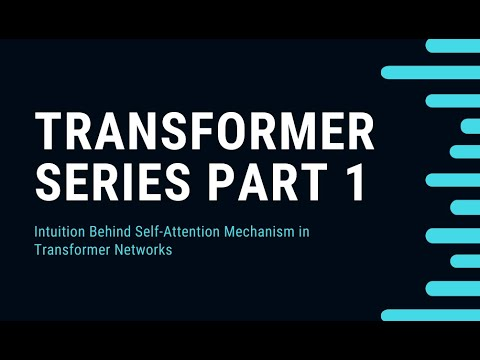

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('g2BRIuln4uc')

## Environment Setup

In [ ]:
# If you are running on Google Colab or outside of HiPerGator
# uncomment the following line to install the needed packages
# HiPerGator users should not need to do this!
#
# !pip install transformers
# !pip install datasets
# !pip install bertviz
# !pip install ipywidgets

In [ ]:
from helper_functions import *
setup_chapter()

Using transformers v4.12.5
Using datasets v1.18.3


In [ ]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

## Attention

![Attention](https://github.com/PracticumAI/transformers/blob/main/images/paint_attention.png?raw=1)

In a nutshell, attention can be defined as follows: Given a request, compare it to the description of each possible item and include some of the content of each item based on how well its description matches the request.  Let's illustrate this process with a story.

Suppose a friend sends us to the paint store with a request for a color that is `light yellow with a bit of dark orange.` But when we get there, the store has no color like that.  It looks like we'll have to mix a custom color.  So how do we do that?  Well, the first step is to search the store's existing inventory, checking the description on each can's label to see how closely it matches the request.  And to the extent it does, we include an appropriate amount of that color. As shown here, equal amounts of Sunny Yellow and Orange Crush have been used.  This makes sense because the labels on these two cans match our request for yellow and orange.  But what about Lunch *with* Teal?  Interestingly, that color is included because our request has the word 'with' in it, as does the can's label.  Thus, a small amount of Lunch **with** Teal is added to the mix.

So far, we've used everyday words to describe the attention process.  But in the literature, these terms are never used, only the technical equivalents listed in the table below. You will encounter this technical vocabulary shortly when we visualize the attention process.

| Everyday       | Technical     | Description                               |
|----------------|---------------|-------------------------------------------|
| Request        | Query         | "Light yellow with a bit of dark orange"  |   
| Description    | Key           | The label on each can of paint            |
| Content        | Value         | What is actually inside each can of paint |

## Heads and Layers

BERT learns multiple attention mechanisms, called **heads**, which operate in parallel to one another. Multi-head attention enables the model to capture a broader range of relationships between words than would be possible with a single attention mechanism.

BERT also stacks multiple **layers** of attention, each of which operates on the output of the layer that came before. Through this repeated composition of word embeddings, BERT is able to form very rich representations as it gets to the deepest layers of the model.

The content in this section is from a wonderul transformer article by [Jesse Vig](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

### 1. Visualize a Simple Sentence

Let's begin by visualizing a simple sentence:  *time flies like an arrow.*


In [ ]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_ckpt)
model      = BertModel.from_pretrained(model_ckpt)

text = "time flies like an arrow"
show(model, "bert", tokenizer, text, display_mode = "light", layer = 0, head = 8)

2022-11-17 09:32:11.898100: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2. Visualize all the Heads

Because the attention heads do not share parameters, each head learns a unique attention pattern. The version of BERT we're using — BERT Base — has 12 layers and 12 heads, resulting in a total of 12 x 12 = 144 distinct attention mechanisms. We can visualize attention in all of the heads at once, using the model view.  In this case, we will visualize all of the heads for the sentence: *The cat sat on the mat.*

The content in this section is from a wonderful transformer article by [Jesse Vig](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

In [ ]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view

utils.logging.set_verbosity_error()                     # Suppress standard warnings

model_name = "microsoft/xtremedistil-l12-h384-uncased"  # Find popular HuggingFace models here: https://huggingface.co/models
input_text = "The cat sat on the mat"                   # The sentence to be visualized

# Configure model to return attention values
model     = AutoModel.from_pretrained(model_name, output_attentions = True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize input text
inputs    = tokenizer.encode(input_text, return_tensors = 'pt')
outputs   = model(inputs)                               # Run model
attention = outputs[-1]                                 # Retrieve attention from model outputs
tokens    = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings

# Display model view
model_view(attention, tokens)

<IPython.core.display.Javascript object>

### 3. Visualize Two Sentences

To get a better sense of how attention works, let's visualize two sentences where the word "flies" has dramatically different meanings.

1. Time **flies** like an arrow
2. Fruit **flies** like a banana

In the first sentence, flies is a verb whereas it acts as a noun (subject) in the second.  As pictured below, the attention mechanism has identified two closely related words, using the word's context - its relationship to other words in the sentence - to do so.

***
<img alt="Contextualized embeddings" caption="Diagram showing how self-attention updates raw token embeddings (upper) into contextualized embeddings (lower) to create representations that incorporate information from the whole sequence" src="https://github.com/PracticumAI/transformers/blob/main/images/contextualized_embedding.png?raw=1" id="contextualized_embedding"/>

In [ ]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors = 'pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim = 1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads = [8])

<IPython.core.display.Javascript object>